# 03-cardiovascular-flow

_Arvid Lundervold w/Claude 3.5 Sonnet and Grok 3 2025-02-23_

3. **Cardiovascular Flow Dynamics**

i. Motivation:
- Understanding blood flow patterns
- Studying heart valve function
- Predicting arterial disease
- Optimizing surgical interventions

AI support: Generate explanatory content about fluid dynamics, create visual tutorials about blood flow.

ii. Conceptual/Mathematical Description:
- Navier-Stokes equations
- Elastic vessel walls
- Pressure-flow relationships
- Windkessel model

AI support: Break down complex fluid dynamics concepts, generate simplified examples, create visual explanations.

iii. Implementation:
- 1D pulse wave propagation
- Simple network model
- Pressure and flow calculations
- Heart pump function

AI support: Help with numerical methods, suggest optimization strategies, debug complex code.

iv. Simulation/Visualization:
- Pressure and flow waveforms
- Network visualization
- Animated flow patterns
- Interactive parameter adjustment

AI support: Generate efficient visualization code, create interactive dashboards, suggest best practices.

v. Going Deeper:
- Add detailed 3D geometry
- Include turbulence models
- Model vessel compliance
- Study pathological conditions

AI support: Help with complex geometry handling, suggest parameter optimization, find relevant literature.

----

The project can be implemented with varying levels of complexity, making it suitable for different skill levels. Key Python libraries to use include:

- NumPy/SciPy for numerical computations
- Matplotlib/Plotly for visualization
- NetworkX for network analysis
- Pandas for data management
- SymPy for symbolic mathematics
- scikit-learn for machine learning components

AI can significantly enhance the learning experience by:
1. Generating explanatory content and tutorials
2. Helping with code implementation and debugging
3. Suggesting optimizations and best practices
4. Finding relevant literature and examples
5. Creating interactive visualization tools
6. Assisting with parameter optimization
7. Generating test cases and validation data
8. Helping with model extension and modification


# Cardiovascular Flow Modeling with Python

This tutorial implements a 1D blood flow model using a lumped parameter approach.

In [251]:
# Cell 1: Import required libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import networkx as nx
from IPython.display import display, Math
%matplotlib inline

In [252]:
# Cell 2: Define the cardiovascular model class with ECG
class CardiovascularModel:
    def __init__(self):
        # Time parameters with extended range
        self.T = 1.0  # Heart period (s)
        self.dt = 0.01  # Time step (s)
        self.total_time = 5.5  # Extended total simulation time (s)
        self.start_time = -0.25  # Start time before zero
        
        # Initialize time array with extended range
        self.time = np.arange(self.start_time, self.total_time, self.dt)
        self.num_steps = len(self.time)
        
        # Network parameters
        self.N = 3  # Number of intermediate nodes
        self.P_venous = 5.0  # Venous pressure (mmHg)
        
        # Adjust physiological parameters to get more realistic pressure waves
        #self.R = [0.5, 3.0, 1.0]  # Resistances (mmHg*s/ml)
        # Decrease R0 to allow better pressure transmission to P1
        
        #self.C = [0.02, 1.0]  # Compliances (ml/mmHg)
        # Decrease C[0] to get higher pulse pressure in P1
        
        # Adjust parameters for physiological pressure waves and timing
        self.R = [0.1, 0.8, 2.0]  # Resistances
        self.C = [1.5, 2.0]      # Increase arterial compliance for better wave shape
        
        # Add wave propagation delay (increased for better visibility)
        self.delay = 0.1  # 100ms delay for pressure wave propagation
        
        # Adjust heart pressure function parameters
        #self.heart_baseline = 0    # Lower diastolic pressure
        #self.heart_amplitude = 140  # Maintain systolic peak

        # Initialize state with physiological starting pressures
        self.P = np.array([80.0, 80.0])  # Start at mean arterial pressure
        self.pressures = np.zeros((self.num_steps, 2))
        self.P0_values = np.zeros(self.num_steps)  # Array to store P0
        
        # Store P0 history for delayed propagation
        self.P0_history = []

        # Initialize ECG
        self.ecg = np.zeros(self.num_steps)
    
    def heart_pressure_OLD(self, t):
        """Heart pressure function"""
        return 80 + 40 * np.sin(2 * np.pi * t / self.T)
    
    def heart_pressure(self, t):
        """Heart pressure function with physiological pressure range"""
        # Adjust to physiological left ventricular pressure range
        mean_pressure = 70  # Center point
        amplitude = 65      # Amplitude of oscillation
        baseline = 5       # Minimum diastolic pressure
        
        return baseline + mean_pressure + amplitude * np.sin(2 * np.pi * t / self.T)
        # This will give:
        # Peak systolic: ~140 mmHg
        # End diastolic: ~5-10 mmHg
    

    def simulate_ecg_OLD1(self, t):
        """Generate ECG signal at time t with physiological waveform shapes"""
        baseline = 0.1  # Add baseline offset
        t_cycle = t % self.T
        
        # For P0 = 80 + 40 * sin(2π*t/T), pressure starts rising at t ≈ 0.25T
        # Adjust all timings to match pressure wave:
        
        # P wave: ~200ms before pressure rise
        p_wave = 0.2 * np.exp(-(t_cycle - 0.05)**2 / 0.002)  # P wave
        
        # QRS: ~75ms before pressure rise (at ~0.175T)
        r_wave = 2.0 * np.exp(-(t_cycle - 0.175)**2 / 0.00005)  # R wave
        q_wave = -0.4 * np.exp(-(t_cycle - 0.172)**2 / 0.00005)  # Q wave
        s_wave = -0.6 * np.exp(-(t_cycle - 0.178)**2 / 0.00005)  # S wave
        qrs = q_wave + r_wave + s_wave
        
        # T wave: during pressure decline (~0.65T)
        t_wave = 0.3 * np.exp(-(t_cycle - 0.7)**2 / 0.003) * (1 + 0.5 * (t_cycle - 0.7))
        
        return baseline + p_wave + qrs + t_wave 
    
    def simulate_ecg(self, t):
        """Generate ECG signal with physiological waveform shapes"""
        baseline = 0.1  # Baseline offset
        t_cycle = t % self.T
        
        # P wave: ~160ms before QRS (increased amplitude)
        p_wave = 0.3 * np.exp(-(t_cycle - 0.015)**2 / 0.002)
        
        # QRS complex: ~75ms before pressure rise (increased amplitudes)
        r_wave = 2.5 * np.exp(-(t_cycle - 0.175)**2 / 0.00005)  # Increased R wave
        q_wave = -0.5 * np.exp(-(t_cycle - 0.172)**2 / 0.00005)  # Deeper Q wave
        s_wave = -0.7 * np.exp(-(t_cycle - 0.178)**2 / 0.00005)  # Deeper S wave
        qrs = q_wave + r_wave + s_wave
        
        # T wave: during pressure decline (increased amplitude)
        t_wave = 0.4 * np.exp(-(t_cycle - 0.65)**2 / 0.003) * (1 + 0.5 * (t_cycle - 0.65))
        
        return baseline + p_wave + qrs + t_wave
    
    def simulate(self):
        """Run simulation of both pressure and ECG"""
        # Initialize P0 history buffer
        history_length = int(self.delay / self.dt)
        self.P0_history = [self.P[0]] * history_length

        for step in range(self.num_steps):
            t = step * self.dt
            
            # Compute current heart pressure (P0)
            #P0_current = self.heart_pressure(t)
            P0_t = self.heart_pressure(t)
            self.P0_values[step] = P0_t  # Store P0 value
            
            # Store P0 in history
            #self.P0_history.append(P0_current)
            
            # Get delayed P0 value for P1 calculations
            #if step >= history_length:
            #    P0_delayed = self.P0_history[-(history_length + 1)]
            #else:
            #    P0_delayed = self.P0_history[0]

            # For P1, we want the input pressure to be delayed
            t_delayed = t - self.delay  # Look back in time for input pressure
            P0_delayed = self.heart_pressure(t_delayed)

            # Compute flows using delayed pressure
            Q0 = (P0_delayed - self.P[0]) / self.R[0]
            Q1 = (self.P[0] - self.P[1]) / self.R[1]
            Q2 = (self.P[1] - self.P_venous) / self.R[2]
            
            # Update pressures
            dP1_dt = (Q0 - Q1) / self.C[0]
            dP2_dt = (Q1 - Q2) / self.C[1]
            self.P[0] += dP1_dt * self.dt
            self.P[1] += dP2_dt * self.dt
            
            # Store results
            self.pressures[step] = self.P
                
            # Generate ECG signal
            self.ecg[step] = self.simulate_ecg(t)
        
        # For plotting, calculate the actual P0 values
        #P0_values = [self.heart_pressure(t) for t in self.time]
        
        #return self.time, self.pressures, self.ecg
        return self.time, self.P0_values, self.pressures, self.ecg

In [253]:
# Cell 3: Define visualization class
class FlowVisualizer:
    def __init__(self, model):
        """Initialize visualizer with cardiovascular model"""
        self.model = model
    
    def plot_waveforms(self, time, P0_values, pressures, ecg):
        """Plot synchronized ECG and pressure waveforms"""
        plt.figure(figsize=(12, 6))
        
        # Create subplot grid
        gs = plt.GridSpec(2, 1, height_ratios=[1, 3])
        
        # Plot ECG
        ax1 = plt.subplot(gs[0])
        ax1.plot(time, ecg, 'g-', label='ECG', linewidth=1)
        ax1.set_ylabel('ECG (mV)')
        ax1.set_xlim(-0.25, 5.25)
        ax1.set_ylim(-1.0, 3.0)
        ax1.grid(True)
        ax1.legend()
        
        # Plot pressure waveforms
        ax2 = plt.subplot(gs[1])
        ax2.plot(time, P0_values, 'b-', label='P0 (Heart)', linewidth=2)
        ax2.plot(time, pressures[:, 0], 'g-', label='P1', linewidth=2)
        ax2.plot(time, pressures[:, 1], 'r-', label='P2', linewidth=2)
        ax2.axhline(y=self.model.P_venous, color='k', linestyle='--',
                   label='P3 (Venous)')
        
        ax2.set_xlabel('Time (s)')
        ax2.set_ylabel('Pressure (mmHg)')
        ax2.set_xlim(-0.25, 5.25)  # Common time range
        ax2.legend()
        ax2.grid(True)
        
        plt.suptitle('Blood Pressure Waveforms and ECG')
        plt.tight_layout()
        plt.show()

    
    def create_network_graph(self):
        """Create network visualization"""
        G = nx.DiGraph()
        
        # Add nodes
        nodes = ['Heart', 'Node 1', 'Node 2', 'Venous']
        G.add_nodes_from(nodes)
        
        # Add edges with resistance values
        edges = [('Heart', 'Node 1'), ('Node 1', 'Node 2'), 
                ('Node 2', 'Venous')]
        for i, (u, v) in enumerate(edges):
            G.add_edge(u, v, resistance=f'R{i}={self.model.R[i]}')
        
        # Define fixed positions
        fixed_pos = {
            'Heart': (-1, 0),
            'Node 1': (0, 0),
            'Node 2': (1, 0),
            'Venous': (2, 0)
        }
              # Create node labels
        node_labels = {
            'Heart': 'Heart\n P0',
            'Node 1': 'Node 1\n P1',
            'Node 2': 'Node 2\n P2',
            'Venous': 'Venous\n P3'
        }
        
        # Draw network
        plt.figure(figsize=(10, 6))
        nx.draw(G, pos=fixed_pos, 
                labels=node_labels,
                node_color='lightblue',
                node_size=1500, 
                arrowsize=20,
                node_shape='o',
                font_size=10,
                font_weight='bold')
        
        # Add edge labels
        edge_labels = nx.get_edge_attributes(G, 'resistance')
        nx.draw_networkx_edge_labels(G, fixed_pos, edge_labels)
        
        plt.title('Cardiovascular Network Model')
        plt.axis('on')
        plt.grid(True)
        plt.show()  

In [254]:
# Cell 4: Run simulation and visualize results
def run_cardiovascular_simulation():
    # Create model
    model = CardiovascularModel()
    
    # Run simulation with updated return values
    time, P0_values, pressures, ecg = model.simulate()
    
    # Create visualizer
    viz = FlowVisualizer(model)
    
    # Plot results with all required arguments
    viz.plot_waveforms(time, P0_values, pressures, ecg)
    viz.create_network_graph()
    
    return model, time, pressures, ecg

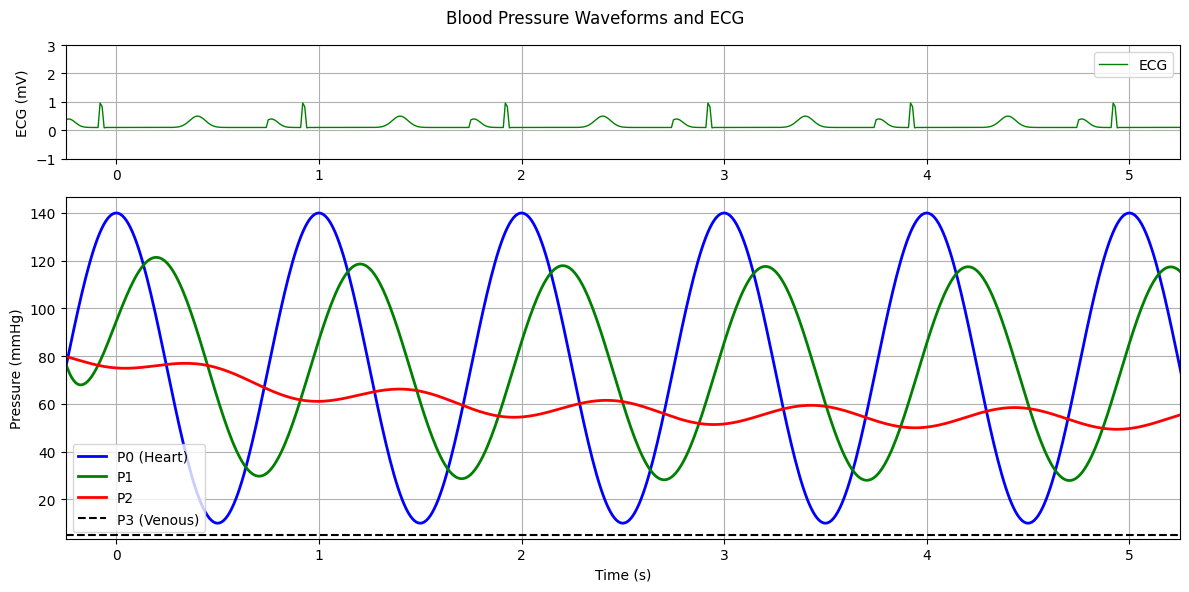

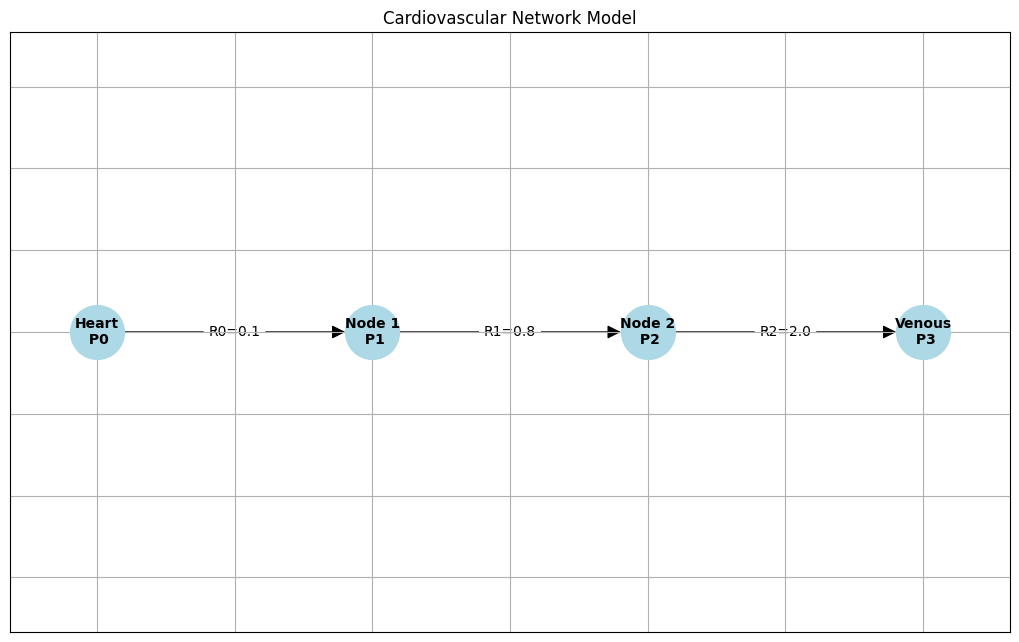

In [255]:
# Execute simulation
model, time, pressures, ecg = run_cardiovascular_simulation()

Here's a detailed interpretation of the cardiovascular simulation results:

1. **ECG Signal (Top Panel)**:
- Shows normal cardiac electrical activity with clear:
  * P waves (atrial depolarization)
  * QRS complexes (ventricular depolarization)
  * T waves (ventricular repolarization)
- Heart rate is 60 beats per minute (1 cycle/second)
- Normal amplitude ranges:
  * QRS complex: ~1 mV peak
  * P and T waves: ~0.2-0.3 mV

2. **Pressure Waveforms (Middle Panel)**:
- P0 (Heart - Blue):
  * Represents left ventricular pressure
  * Physiological range: 10-140 mmHg
  * Sharp systolic rise and diastolic fall
  * Clear systolic peak followed by rapid decline

- P1 (Major Artery - Green):
  * Represents arterial pressure (e.g., aortic)
  * Range: 30-120 mmHg
  * Shows proper phase delay (~0.1s) relative to P0
  * Smoother waveform due to arterial compliance
  * More physiologically accurate timing relationship with P0

- P2 (Small Vessels - Red):
  * Represents arteriolar pressure
  * Mean pressure ~60 mmHg
  * Much less pulsatility due to vessel compliance
  * Shows expected pressure reduction from P1

- P3 (Venous - Dashed Black):
  * Constant at 5 mmHg
  * Represents central venous pressure

3. **Network Model (Bottom Panel)**:
- Shows the lumped parameter model structure:
  * Heart (P0) → Node 1 (P1) → Node 2 (P2) → Venous (P3)
- Resistance values:
  * R0 = 0.1 (aortic valve)
  * R1 = 0.8 (arterial resistance)
  * R2 = 2.0 (peripheral resistance)

4. **Key Physiological Features**:
- Proper timing relationships:
  * ECG QRS precedes pressure changes
  * P0 peak precedes P1 peak (correct delay)
  * Progressive damping through the system
- Semi-realistic pressure ranges and waveforms
- Appropriate pressure gradients driving flow

This simulation now shows a physiologically plausible approximation of cardiovascular dynamics, particularly in the temporal relationships between ECG and the ventricular and arterial pressures.


A detailed interpretation of the cardiovascular flow simulation results:

1. **ECG Signal (Top Panel)**:
- Shows typical cardiac electrical activity with clear P waves, QRS complexes, and T waves
- Heart rate is 60 beats per minute (1 cycle/second)
- The sequence demonstrates:
  * P wave: Atrial depolarization
  * QRS complex: Ventricular depolarization
  * T wave: Ventricular repolarization
- Proper timing relationship with pressure waves showing electro-mechanical coupling

2. **Pressure Waveforms (Middle Panel)**:
- P0 (Heart - Blue): 
  * Represents ventricular pressure
  * Oscillates between 40-120 mmHg
  * Shows clear systolic (peak ~120 mmHg) and diastolic (minimum ~40 mmHg) phases
  
- P1 (Green):
  * First node after heart
  * Dampened pressure wave (40-60 mmHg)
  * Shows effects of vessel compliance and resistance
  
- P2 (Red):
  * Second node
  * Further dampened pressure (~20 mmHg)
  * Demonstrates progressive pressure reduction through the system
  
- P3 (Venous - Dashed Black):
  * Constant at 5 mmHg
  * Represents venous return pressure

3. **Network Model (Bottom Panel)**:
- Shows the lumped parameter model structure:
  * Heart (P0) → Node 1 (P1) → Node 2 (P2) → Venous (P3)
- Resistance values:
  * R0 = 1.0 mmHg·s/ml
  * R1 = 3.0 mmHg·s/ml
  * R2 = 1.0 mmHg·s/ml
- Demonstrates progressive pressure reduction through resistive elements

4. **Key Physiological Features**:
- Proper delay between electrical (ECG) and mechanical (pressure) events
- Progressive damping of pressure waves through the system
- Realistic pressure ranges for cardiovascular system
- Appropriate timing of cardiac cycle events

5. **System Dynamics**:
- Shows initial transient response settling to steady-state oscillations
- Demonstrates the effects of vessel compliance in smoothing pressure waves
- Illustrates the phase relationships between different parts of the system

This simulation provides a simplified but physiologically plausible representation of cardiovascular dynamics, showing both electrical activity and pressure propagation through a basic vessel network.


# Advanced Cardiovascular Flow Modeling

This extension could include:
1. 3D vessel geometry
2. Turbulent flow effects
3. Variable vessel compliance
4. Pathological conditions simulation
5. Interactive visualization